<a href="https://colab.research.google.com/github/gaiii123/Building-a-Hybrid-Retail-Analytics-Pipeline-with-Spark-and-R/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Retail_Data_Engineering_Project") \
    .master("local[*]") \
    .getOrCreate()

print("Spark Engine Online.")

file_name = "online_retail_II.xlsx"

try:
    df_raw = spark.read.format("csv") \
      .option("header", "true") \
      .option("inferSchema", "true") \
      .load(file_name)

    print("Data Ingestion Successful!")
    print(f"Total Records Loaded: {df_raw.count()}")

    print("--- Raw Schema ---")
    df_raw.printSchema()
    df_raw.show(5)

except Exception as e:
    print("Error! Could not find the file.")
    print(e)

Spark Engine Online.
Data Ingestion Successful!
Total Records Loaded: 214631
--- Raw Schema ---
root
 |-- PK  \b   ! ��d     \b[Content_Types].xml �(�                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Ĕ�n�0\f���U�S�0M���7��\a�C#�$�: string (nullable = true)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
import pandas as pd

input_excel_filename = "online_retail_II.xlsx"

print("Step 1: Reading Excel file with Pandas (This might take 1 minute)...")
try:
    pdf = pd.read_excel(input_excel_filename)

    # Convert to CSV
    output_csv_name = "online_retail_converted.csv"
    pdf.to_csv(output_csv_name, index=False)
    print(f"Success! Converted '{input_excel_filename}' to '{output_csv_name}'")

    # Load the NEW CSV into Spark
    print("Step 2: Loading converted data into Spark...")
    df_clean = spark.read.format("csv") \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .load(output_csv_name)

    print("--- Data Schema ---")
    df_clean.printSchema()

    print("--- Top 5 Rows ---")
    df_clean.show(5)

except Exception as e:
    print("Error during conversion. Please check if the filename matches exactly.")
    print(e)

Step 1: Reading Excel file with Pandas (This might take 1 minute)...
Success! Converted 'online_retail_II.xlsx' to 'online_retail_converted.csv'
Step 2: Loading converted data into Spark...
--- Data Schema ---
root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

--- Top 5 Rows ---
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PIN

In [6]:
from pyspark.sql.functions import col, count, when, isnan

print(f"Original Record Count: {df_clean.count()}")

Original Record Count: 525461


In [7]:
print("--- Missing Value Count ---")
df_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in df_clean.columns]).show()


--- Missing Value Count ---
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|       2928|       0|          0|    0|     107927|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+



In [9]:
# Remove rows with no Customer ID (we can't use them for segmentation)
# Remove rows with negative Quantity (Returns/Cancellations)
# Remove rows with negative/zero Price
df_silver = df_clean.filter(col("Customer ID").isNotNull()) \
    .filter(col("Quantity") > 0) \
    .filter(col("Price") > 0)

In [10]:

# Create a new column 'TotalSales'
df_silver = df_silver.withColumn("TotalSales", col("Quantity") * col("Price"))

# 4. Final Quality Check
print(f"Cleaned Record Count: {df_silver.count()}")
print("--- Silver Layer Preview ---")
df_silver.select("Invoice", "StockCode", "Quantity", "Price", "TotalSales").show(5)

Cleaned Record Count: 407664
--- Silver Layer Preview ---
+-------+---------+--------+-----+------------------+
|Invoice|StockCode|Quantity|Price|        TotalSales|
+-------+---------+--------+-----+------------------+
| 489434|    85048|      12| 6.95|              83.4|
| 489434|   79323P|      12| 6.75|              81.0|
| 489434|   79323W|      12| 6.75|              81.0|
| 489434|    22041|      48|  2.1|100.80000000000001|
| 489434|    21232|      24| 1.25|              30.0|
+-------+---------+--------+-----+------------------+
only showing top 5 rows


In [11]:
from pyspark.sql.functions import round

# Round the 'TotalSales' to 2 decimal places (fix that 100.8000001 issue)
df_final = df_silver.withColumn("TotalSales", round(col("TotalSales"), 2))

#  Save as a Single CSV file
output_folder = "Gold_Sales_Data"
df_final.coalesce(1).write.mode("overwrite").option("header", "true").csv(output_folder)

print(f"Success! Cleaned data saved to folder: {output_folder}")

Success! Cleaned data saved to folder: Gold_Sales_Data


In [12]:
# Scenario: Monitor incoming sales files and flag orders > $500 immediately.

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

schema = StructType([
    StructField("Invoice", StringType(), True),
    StructField("StockCode", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("InvoiceDate", TimestampType(), True),
    StructField("Price", DoubleType(), True),
    StructField("Customer ID", DoubleType(), True),
    StructField("Country", StringType(), True)
])

input_path = "stream_input"
dbutils.fs.mkdirs(input_path) if 'dbutils' in globals() else None
import os; os.makedirs(input_path, exist_ok=True)

streaming_df = spark.readStream \
    .schema(schema) \
    .option("header", "true") \
    .csv(input_path)

stream_clean = streaming_df.withColumn("TotalSales", col("Quantity") * col("Price"))
high_value_alerts = stream_clean.filter(col("TotalSales") > 500) \
    .select("Invoice", "Description", "TotalSales", "Country")

query = high_value_alerts.writeStream \
    .format("memory") \
    .queryName("alerts_view") \
    .outputMode("append") \
    .start()

print("Streaming Engine is ON.")

Streaming Engine is ON. Waiting for data in 'stream_input' folder...


In [13]:
import time
import pandas as pd

print("Generating live transaction...")
data = {
    'Invoice': ['LIVE_001'],
    'StockCode': ['M_TEST'],
    'Description': ['Macbook Pro - REAL TIME SALE'],
    'Quantity': [1],
    'InvoiceDate': ['2025-12-14 10:00:00'],
    'Price': [1200.00],
    'Customer ID': [99999.0],
    'Country': ['United Kingdom']
}

live_df = pd.DataFrame(data)
live_df.to_csv(f"stream_input/transaction_{int(time.time())}.csv", index=False)

print("Transaction sent to stream! Waiting for processing...")
time.sleep(5)

results = spark.sql("SELECT * FROM alerts_view")
results.show()

Generating live transaction...
Transaction sent to stream! Waiting for processing...
+--------+--------------------+----------+--------------+
| Invoice|         Description|TotalSales|       Country|
+--------+--------------------+----------+--------------+
|LIVE_001|Macbook Pro - REA...|    1200.0|United Kingdom|
+--------+--------------------+----------+--------------+



In [14]:

%load_ext rpy2.ipython

print("R Extension Loaded.")

R Extension Loaded. We can now switch languages!


In [15]:

# Aggregate Sales by Country (Group By)
df_country_stats = df_final.groupBy("Country") \
    .sum("TotalSales") \
    .withColumnRenamed("sum(TotalSales)", "Revenue") \
    .orderBy("Revenue", ascending=False) \
    .limit(10) # Top 10 Countries

# Convert to Pandas (Local Data)
pdf_country_stats = df_country_stats.toPandas()

# Aggregate Monthly Sales for a Trend Chart
from pyspark.sql.functions import trunc
df_monthly = df_final.withColumn("Month", trunc("InvoiceDate", "month")) \
    .groupBy("Month") \
    .sum("TotalSales") \
    .withColumnRenamed("sum(TotalSales)", "Revenue") \
    .orderBy("Month")

pdf_monthly_stats = df_monthly.toPandas()

print("Data converted to Pandas. Ready for R ingestion.")
display(pdf_country_stats)

Data converted to Pandas. Ready for R ingestion.


,Country,Revenue
0,United Kingdom,7.414756e+06
1,EIRE,3.560852e+05
2,Netherlands,2.687860e+05
3,Germany,2.023953e+05
4,France,1.462154e+05
5,Sweden,5.317139e+04
6,Denmark,5.090685e+04
7,Spain,4.760142e+04
8,Switzerland,4.392139e+04
9,Australia,3.144680e+04


Keep up to date with changes at https://tidyverse.org/blog/


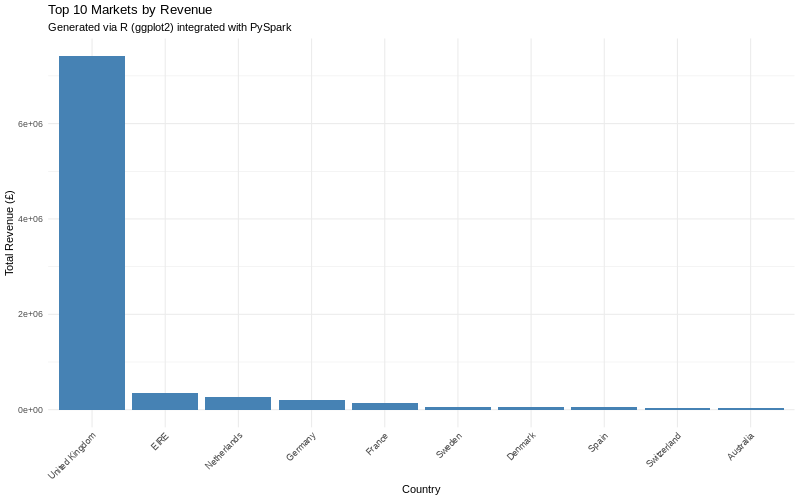

In [16]:
%%R -i pdf_country_stats -w 800 -h 500 -u px

library(ggplot2)

plot_country <- ggplot(pdf_country_stats, aes(x = reorder(Country, -Revenue), y = Revenue)) +
  geom_col(fill = "steelblue") +

  labs(title = "Top 10 Markets by Revenue",
       subtitle = "Generated via R (ggplot2) integrated with PySpark",
       x = "Country",
       y = "Total Revenue (£)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate labels

print(plot_country)

`geom_smooth()` using formula = 'y ~ x'


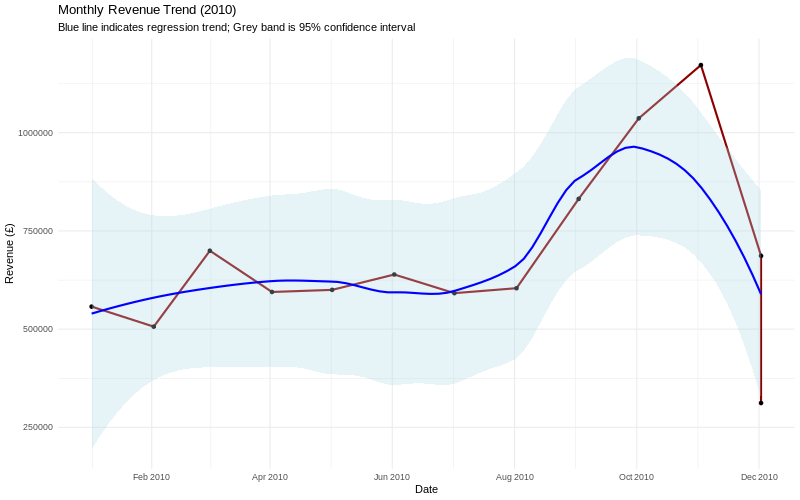

In [24]:
%%R -i pdf_monthly_stats -w 800 -h 500 -u px

library(ggplot2)
library(scales)


pdf_monthly_stats$Month <- as.Date(format(as.Date(pdf_monthly_stats$Month), "2010-%m-%d"))

plot_trend <- ggplot(pdf_monthly_stats, aes(x = Month, y = Revenue)) +
  geom_line(color = "darkred", size = 1) +
  geom_point() +

  geom_smooth(method = "loess", color = "blue", fill = "lightblue", alpha = 0.3) +

  scale_x_date(date_labels = "%b %Y", date_breaks = "2 months") +

  labs(title = "Monthly Revenue Trend (2010)",
       subtitle = "Blue line indicates regression trend; Grey band is 95% confidence interval",
       x = "Date",
       y = "Revenue (£)") +
  theme_minimal()

print(plot_trend)

In [25]:
%%R
install.packages("forecast")
library(forecast)
print("Forecast library installed and ready!")

[1] "Forecast library installed and ready!"


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/forecast_8.24.0.tar.gz'
Content type 'application/x-gzip' length 581947 bytes (568 KB)
downloaded 568 KB


The downloaded source packages are in
	‘/tmp/RtmpkeikhP/downloaded_packages’


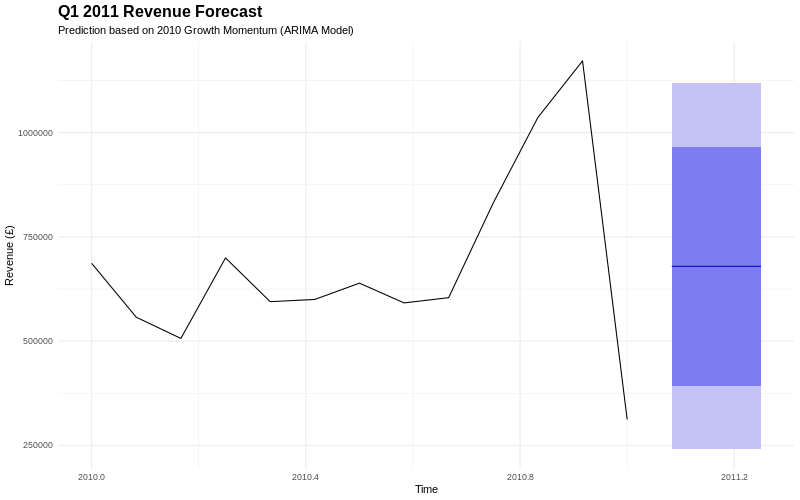

In [23]:
%%R -i pdf_monthly_stats -w 800 -h 500 -u px

ts_revenue <- ts(pdf_monthly_stats$Revenue, start=c(2010, 1), frequency=12)

fit_model <- auto.arima(ts_revenue)

forecast_2011 <- forecast(fit_model, h=3)

autoplot(forecast_2011) +
  labs(title = "Q1 2011 Revenue Forecast",
       subtitle = "Prediction based on 2010 Growth Momentum (ARIMA Model)",
       x = "Time",
       y = "Revenue (£)") +
  theme_minimal() +
  theme(plot.title = element_text(size=16, face="bold"))